#Mounting Google Drive account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Libraries

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import h5py
import os
import time
import scipy
import scipy.io
from PIL import ImageOps
import PIL.Image
from PIL import ImageTk, Image
from scipy import ndimage
import time
import h5py
import tkinter
from tkinter import * 
from tkinter import filedialog
from tkinter.filedialog import askopenfilename
from tkinter import messagebox
from tkinter.messagebox import *


#set default size of plots
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#set seed
np.random.seed(1)

#Class: Deep Learning Layer

In [ ]:
class DLLayer:
    def __init__(self, name, num_units, input_shape, activation = "relu", W_initialization = "random", learning_rate = 0.01, optimization = "None", regularization = "None"):
        #class attributes
        self.name = name
        self.num_units = num_units
        self.input_shape = input_shape
        self.activation = activation
        self.alpha = learning_rate
        self.learning_rate = learning_rate
        self.activation_forward = getattr(self,activation)
        self.leaky_relu_d = 0.01
        self.activation_backward = getattr(self,activation+"_backward")
        self.activation_trim = 1e-10
        self.adaptive_cont = 1.1
        self.adaptive_switch = 0.5
        self.random_scale = 0.1 # 0.01 / 10
        self.optimization = optimization
        self.W_initialization = W_initialization
        self.regularization = regularization
        if regularization == "L2":
          self.L2_lambda = 0.1
        if regularization == "dropout":
          self.dropout_keep_prob = 0.8
        if optimization == "adaptive":
            self.adaptive_alpha_b = np.full((self.num_units, 1), self.alpha)
            self.adaptive_alpha_W = np.full((self.num_units, *(self.input_shape)), self.alpha)
        self.init_weights(W_initialization)

    def get_W_shape(self):
      return(self.num_units,self.input_shape[0])

    def init_weights(self, W_initialization):
        self.b = np.zeros((self.num_units,1), dtype=float)
        if W_initialization == "zeros":
            self.W = np.full(self.get_W_shape(), 0.0)
        elif W_initialization == "random":
            self.W = np.random.randn(*self.get_W_shape()) * self.random_scale
        elif W_initialization=="Xaviar":
          self.W = np.random.randn(self.num_units,sum(self.input_shape))*np.sqrt(2/sum(self.input_shape))
        elif W_initialization=="He":
          self.W = np.random.randn(self.num_units,sum(self.input_shape))*np.sqrt(1/sum(self.input_shape))
        else:
          try:
            with h5py.File(W_initialization, 'r') as hf:
              self.W = hf['W'][:]
              self.b = hf['b'][:]
          except (FileNotFoundError):
            raise NotImplementedError("Unrecognized initialization:", W_initialization)


    def __str__(self):
      s = self.name + " Layer:\n"
      s += "\tnum_units: " + str(self.num_units) + "\n"
      s += "\tactivation: " + self.activation + "\n"

      if self.activation == "leaky_relu":
        s += "\t\tleaky relu parameters:\n"
        s += "\t\t\tleaky_relu_d: " + str(self.leaky_relu_d)+"\n"
      s += "\tinput_shape: " + str(self.input_shape) + "\n"
      s += "\tlearning_rate (alpha): " + str(self.alpha) + "\n"
      #optimization
      if self.optimization == "adaptive":
        s += "\t\tadaptive parameters:\n"
        s += "\t\t\tcont: " + str(self.adaptive_cont)+"\n"
        s += "\t\t\tswitch: " + str(self.adaptive_switch)+"\n"
      #regularization
      if self.regularization != "None":
        s += "\t\tregularization:\n"
        s += str(self.regularization)+"\n"
        if self.regularization == "L2":
          s += "\t\tlambda:\n"
          s += str(self.L2_lambda) + "\n"
        if self.regularization == "dropout":
          s += "\t\tdropout keep prob:\n"
          s += str(self.dropout_keep_prob) + "\n"

    # parameters
      s += "\tparameters:\n\t\tb.T: " + str(self.b.T) + "\n"
      s += "\t\tshape weights: " + str(self.W.shape)+"\n"
      plt.hist(self.W.reshape(-1))
      plt.title("W histogram")
      plt.show()
      return s; 
    """
    Deep learning layers functions
    """
    def sigmoid(self,Z):
      return 1/(1+np.exp(-Z))
    def tanh(self,Z):
      return np.tanh(Z)
    def relu(self,Z):
      return np.maximum(np.zeros(Z.shape),Z)
    def leaky_relu(self,Z): 
      return np.where(Z<=0,self.leaky_relu_d*Z,Z)
    def sigmoid_backward(self,dA):
      A = self.sigmoid(self.Z)
      dZ = dA*A*(1-A)
      return dZ
    def tanh_backward(self,dA):
      A = self.tanh(self.Z)
      dZ = dA (1-A*2)
      return dZ
    def relu_backward(self,dA):
      dZ = np.where(self.Z<=0,0,dA)
      return dZ
    def leaky_relu_backward(self,dA):
      dZ = np.where(self.Z<=0,self.leaky_relu_d*dA,dA)
      return dZ

    def trim_sigmoid(self,Z):
      with np.errstate(over='raise',divide='raise'):
        try:
          A = 1/(1+np.exp(-Z))
        except FloatingPointError:
          Z = np.where(Z < -100, -100,Z)
          A = A = 1/(1+np.exp(-Z))
        TRIM = self.activation_trim
        if TRIM > 0:
          A = np.where(A < TRIM,TRIM,A)
          A = np.where(A > 1-TRIM,1-TRIM, A)
        return A
    
    def trim_sigmoid_backward(self,dA):
        A = self.trim_sigmoid(self.Z)
        dZ = dA * A * (1-A)
        return dZ

    def trim_tanh(self,Z):
      A = np.tanh(Z)
      TRIM = self.activation_trim
      if TRIM > 0:
        A = np.where(A < -1+TRIM,TRIM,A)
        A = np.where(A > 1-TRIM,1-TRIM, A)
      return A

    def trim_tanh_backward(self,dA):
      A = self.trim_tanh(self.Z)
      dZ = dA*(1-A**2)
      return dZ
    
    def trim_softmax(self, Z):
      with np.errstate(over='raise', divide='raise'):
        try:
          eZ = np.exp(Z)
        except FloatingPointError:
          Z = np.where(Z > 100, 100,Z)
          eZ = np.exp(Z)
      A = eZ/np.sum(eZ, axis=0)
      return A
    
    def trim_softmax_backward(self, dZ):
      return dZ

    def softmax(self,Z):
      return np.exp(Z)/np.sum(np.exp(Z),axis=0,keepdims=True)

    def softmax_backward(self, dZ):
      return dZ

    def forward_propagation(self,A_prev,is_predict):
      self.A_prev = np.array(A_prev, copy=is_predict) 
      if is_predict == False and self.regularization == "dropout":
        self.D = np.random.random(self.A_prev.shape)
        self.D = np.where(self.D < self.dropout_keep_prob, 0, 1)
        self.A_prev = self.A_prev * self.D
        self.A_prev = self.A_prev / self.dropout_keep_prob
      self.Z = self.W@self.A_prev+self.b
      A = self.activation_forward(self.Z)
      return A

    def backward_propagation(self,dA):
      dZ = self.activation_backward(dA) 
      dA_prev = self.W.T@dZ
      self.dW = (1/self.num_units)*(dZ@(self.A_prev).T)
      self.db = (1/self.num_units)*(np.sum(dZ,axis=1,keepdims=True))
      if self.regularization == "dropout":
        dA_prev = dA_prev * self.D
        dA_prev = dA_prev / self.dropout_keep_prob
      return dA_prev

    def update_parameters(self):
      if self.optimization=="None":
        self.W -= self.dW*self.learning_rate
        self.b -= self.db*self.learning_rate 
      else:
        self.adaptive_alpha_W = np.where(self.dW*self.adaptive_alpha_W>0,self.adaptive_alpha_W*self.adaptive_cont,self.adaptive_alpha_W*-1*self.adaptive_switch)
        self.adaptive_alpha_b = np.where(self.db*self.adaptive_alpha_b>0,self.adaptive_alpha_b*self.adaptive_cont,self.adaptive_alpha_b*-1*self.adaptive_switch)
        self.W = self.W - self.adaptive_alpha_W
        self.b =  self.b- self.adaptive_alpha_b
    
    def save_weights(self,path,file_name):
      if not os.path.exists(path):
        os.makedirs(path)
      with h5py.File(path+"/"+file_name+'.h5','w') as hf:
        hf.create_dataset("W", data=self.W)
        hf.create_dataset("b",data=self.b)

    def parms_to_vec(self):
      return np.concatenate((np.reshape(self.W,(-1)),np.reshape(self.b,(-1,))),axis=0)
    
    def vec_to_parms(self,vec):
      self.W = vec[0:self.W.size].reshape(self.W.shape)
      self.b = vec[self.W.size:].reshape(self.b.shape)

    def gradients_to_vec(self):
      return np.concatenate(self.dW,self.db)
      return np.concatenate((np.reshape(self.dW,(-1,)),np.reshape(self.db, (-1,))), axis=0) # orig one

#Class: Deep Learning Model

In [ ]:
class DLModel:
    def __init__(self, name = "Model"):
        #class attributes
        self.name = name
        self.layers = [None]
        self.is_compiled = False
    
    """
    Function adds deep learning layer to the model
    """
    def add(self, layer):
        self.layers.append(layer)
    def squared_means(self, AL, Y):
        return (Y-AL)**2
    def squared_means_backward(self, AL, Y):
        return 2*(AL-Y)

    """
    Possible error functions
    """
    def cross_entropy(self, AL, Y):
        self.error = np.where(Y==0, -np.log(1-AL), -np.log(AL))
        return self.error
    def cross_entropy_backward(self, AL, Y):
        dAL = np.where(Y==0, 1/(1-AL), -1/AL)
        return dAL
    def categorical_cross_entropy(self, AL, Y):
        return np.where(Y==1, -np.log(AL), 0)
    def categorical_cross_entropy_backward(self, AL, Y):
        return AL-Y
        
    """
    Compile model and set attributes ready for training
    """
    def compile(self, loss, threshold = 0.5):
        self.loss = loss
        self.loss_forward = getattr(self, loss)
        self.loss_backward = getattr(self, loss+ "_backward")
        self.threshold = threshold
        self.is_compiled = True
    def compute_cost(self, AL, Y):
        m = len(AL[0])
        error = self.loss_forward(AL, Y)
        costs = 2*np.sum(error) / m
        sumbda = 0
        for i in range (1,len(self.layers)):
          if self.layers[i].regularization == "L2":
            sumbda = sumbda + (self.layers[i].L2_lambda/(2*m))*np.sum(np.square(self.layers[i].W))
        return (costs + sumbda)

    """
    Model training function:
    : Gets training dataset by X,Y
    : return lists of all costs during the training
    """
    def train(self, X, Y, num_iterations):
        print_ind = max(num_iterations // 100, 1)
        L = len(self.layers)
        costs = []
        for i in range(num_iterations):
            # forward propagation
            Al = X
            for l in range(1,L):
                Al = self.layers[l].forward_propagation(Al,False)
            #backward propagation
            dAl = self.loss_backward(Al, Y)
            for l in reversed(range(1,L)):
                dAl = self.layers[l].backward_propagation(dAl)
                # update parameters
                self.layers[l].update_parameters()
            #record progress
            if i> 0 and i % print_ind == 0:
                J = self.compute_cost(Al, Y)
                costs.append(J)
                print("cost after " , str(i//print_ind), "%: ", str(J))

                #Avoid useless training after arriving to wanted result
                if str(J) == "0.0" or str(J) == "nan":
                  return costs   
        return costs
      

    """
    Function uses model to classify an example
    : Get an example
    : Return list of indexes when 1 is the classified category
    """
    def predict(self, X):
        L = len(self.layers)
        Al = X
        for l in range(1,L):
            Al = self.layers[l].forward_propagation(Al,True)
            if(self.layers[l].activation == "softmax" or self.layers[l].activation == "trim_softmax"):
              Al = np.where(Al==Al.max(axis=0), 1, 0)
              return Al
        return Al

    """
    To_String function
    :Return short description and information about the model
    """
    def __str__(self):
        s = self.name + " description:\n\tnum_layers: " + str(len(self.layers)-1) +"\n"
        if self.is_compiled:
            s += "\tCompilation parameters:\n"
            s += "\t\tprediction threshold: " + str(self.threshold) +"\n"
            s += "\t\tloss function: " + self.loss + "\n\n"
        for i in range(1,len(self.layers)):
            s += "\tLayer " + str(i) + ":" + str(self.layers[i]) + "\n"
        return s

    """
    Function loads an existing model
    : Gets file path (".h5")
    """
    def load_model(self, path):
        try:
            with h5py.File(path, 'r') as hf:
                self.W = hf['W'][:]
                self.b = hf['b'][:]
        except (FileNotFoundError):
                raise NotImplementedError("Unrecognized initialization:")


    def check_backward_propagation(self, X, Y, epsilon=1e-7):
      L = len(self.layers)
      vec_parms = np.zeros(len(Y), dtype = object)
      vec_grad = np.zeros(len(Y), dtype = object)
      Al = X
      for i in reversed(range(1, L)):
         Al = self.layers[i].forward_propagation(Al,False)
      dAl = self.loss_backward(Al, Y)
      for i in reversed(range(1, L)):
         dAl = self.layers[i].backward_propagation(dAl)
         self.layers[i].update_parameters()
         vec_parms = self.layers[i].parms_to_vec()
         vec_grad = self.layers[i].gradients_to_vec()
      diff = (np.linalg.norm(vec_grad - Al))/(np.linalg.norm(vec_grad) + np.linalg.norm(Al))
      for i in range(L):
        if diff[i] < epsilon:
          return False, diff, i
      return True, diff, L-1
    @staticmethod
    def to_one_hot(num_categories, Y):
      m = Y.shape[1]
      Y_new = np.eye(num_categories)[Y.astype('int32')]
      Y_new = Y_new.T.reshape(num_categories, m)
      return Y_new

    """
    Function calculates the model accuracy by trained and tested data
    """
    def confusion_matrix(self, X, Y):
      prediction = self.predict(X)
      prediction_index = np.argmax(prediction, axis=0)
      Y_index = np.argmax(Y, axis=0)
      right = np.sum(prediction_index == Y_index)
      print("accuracy: ",str(right/len(Y[0])))
      print(confusion_matrix(prediction_index, Y_index))


    def save_model(self, path, file_name):
      if not os.path.exists(path):
        os.os.makedirs(path)
      with h5py.File(path + "/" + file_name + ".h5", "w") as hf:
      
        hf.create_dataset("W", data=self.W)
        hf.create_dataset("b", data=self.b)

#Load images from dataset (Goolge Drive)

In [ ]:
from PIL import ImageTk, Image
DOG_PATH = "drive/My Drive/dogcats/dog/"
CAT_PATH = "drive/My Drive/dogcats/cat/"

def load_dataset(dogs_path=DOG_PATH, cats_path=CAT_PATH):
  try:
    #get files list from each directory
    dog_files = os.listdir(dogs_path)

    cat_files = os.listdir(cats_path)
  except Exception as E:
    raise Exception("directories don't exist")


  #declare necessery constants for more readable code
  CAT = 1
  DOG = 0

  RESIZED_WEIGHT = 64
  RESIZED_HEIGHT = 64

  ys = []
  xs = []

  #run over the files 
  for dog, cat in zip(dog_files, cat_files):
  
    ys.append(DOG)
    img = Image.open(dogs_path + dog)
    img64 = img.resize((RESIZED_WEIGHT, RESIZED_HEIGHT), Image.ANTIALIAS) # Resize images to wanted resolution
    grayscale = ImageOps.grayscale(img64)                                 # Change image color to grayscale
    xs.append((np.array(grayscale) / 255 - 0.5).flatten())


    ys.append(CAT)
    img = Image.open(cats_path + cat)
    img64 = img.resize((RESIZED_WEIGHT, RESIZED_HEIGHT), Image.ANTIALIAS) # Resize images to wanted resolution
    grayscale = ImageOps.grayscale(img64)                                 # Change image color to grayscale
    xs.append((np.array(grayscale) / 255 - 0.5).flatten())


  #Split dataset to train and test
  train_x, test_x, train_y, test_y = train_test_split(np.array(xs), np.array(ys).T)
  X_train = train_x.T
  X_test = test_x.T
  Y_train = np.array(train_y)
  Y_train = Y_train.reshape(1,-1)
  Y_test = np.array(test_y)
  Y_test = Y_test.reshape(1,-1)

  Y_train = DLModel.to_one_hot(2, Y_train)
  Y_test = DLModel.to_one_hot(2, Y_test)

  return X_train, Y_train, X_test, Y_test

#Creates the model

In [ ]:
"""
Function gets dataset and train the model.
: Gets X_train and Y_train data
"""

def own_model_training(X_train, Y_train):

  #Create deep learning layers
  layer1 = DLLayer("Layer 1", 16, (4096,), W_initialization="Xaviar" ,optimization="adaptive")
  layer2 = DLLayer("Layer 2", 32, (16,), W_initialization="Xaviar", optimization="adaptive")
  layer3 = DLLayer("Layer 3", 16, (32,), W_initialization="Xaviar",  optimization="adaptive", regularization="dropout")
  layer4 = DLLayer("Layer 4", 8, (16,), W_initialization="Xaviar", optimization="adaptive")
  output = DLLayer("Output", 2, (8,), activation="softmax", W_initialization="Xaviar", optimization="adaptive")

  #define model and add the layers
  model = DLModel()
  model.add(layer1)
  model.add(layer2)
  model.add(layer3)
  model.add(layer4)
  model.add(output)
  model.compile("categorical_cross_entropy")


  #train the model
  model.train(X_train, Y_train, 1000)

  return model

In [ ]:
#X_train, Y_train, X_test, Y_test = load_dataset()
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)
model = own_model_training(X_train, Y_train)
#print(Y_train[0])


X_train:  (4096, 750)
Y_train:  (2, 750)
X_test:  (4096, 250)
Y_test:  (2, 250)
cost after  1 %:  1.1916012861086092
cost after  2 %:  1.018806235902874
cost after  3 %:  0.9121034157066475
cost after  4 %:  0.8411651219354197
cost after  5 %:  0.8493822416960989
cost after  6 %:  0.8074267376520966
cost after  7 %:  0.7686934373343931
cost after  8 %:  0.7773190095388578
cost after  9 %:  0.7866899360762801
cost after  10 %:  0.8226789466563217
cost after  11 %:  0.7640663212817645
cost after  12 %:  0.7563196845697929
cost after  13 %:  0.7960126988757984
cost after  14 %:  0.7327850839876932
cost after  15 %:  0.7962127354854377
cost after  16 %:  0.7243085907372918
cost after  17 %:  0.7362235616071039
cost after  18 %:  0.7501948070968346
cost after  19 %:  0.7722208403176741
cost after  20 %:  0.7388989656936554
cost after  21 %:  0.7284966951204648
cost after  22 %:  0.7066146280285008
cost after  23 %:  0.7222735631351309
cost after  24 %:  0.7118804589079949
cost after  25 %: 

#Calculate accuracy

In [ ]:
def display_accuracy(model, X_train, Y_train, X_test, Y_test):
  print("Train:")
  model.confusion_matrix(X_train, Y_train)
  print("Test:")
  model.confusion_matrix(X_test, Y_test)

In [ ]:
display_accuracy(model, X_train, Y_train, X_test, Y_test)

Train:
accuracy:  0.9173333333333333
[[332  26]
 [ 36 356]]
Test:
accuracy:  0.824
[[102  14]
 [ 30 104]]


#Tests on external examples (Google)

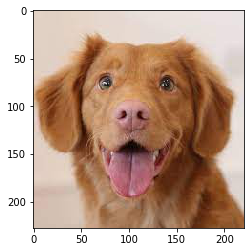

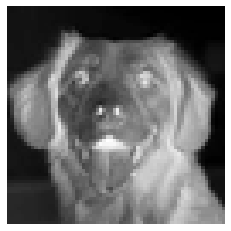

dog
[[1]
 [0]]


In [ ]:
predict_image(model, "Dogg.jpg")

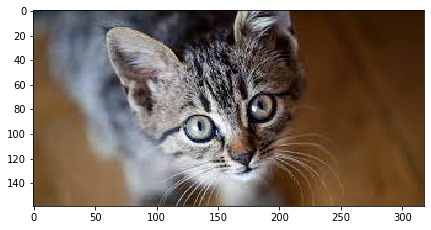

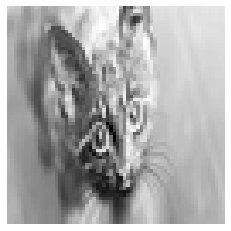

cat
[[0]
 [1]]


In [ ]:
predict_image(model, "catt.jpg")

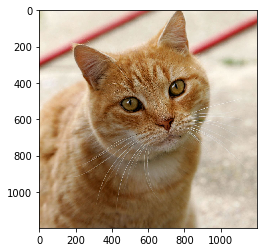

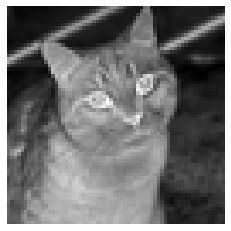

cat
[[0]
 [1]]


In [ ]:
predict_image(model, "Cat03.jpg")

In [ ]:
from PIL import ImageTk, Image
classification = {0 : "dog", 1 : "cat"}

"""
Function helps test model on external examples
: Gets path of example, A model to use
: Return the class that associate with the example
"""
def predict_image(model, path="ask"):

  if path == "ask":
    path = input("Enter image path: ")

  #Display Normal Image
  num_px = 64
  img_path = path
  image = PIL.Image.open(img_path)
  image28 = image.resize((num_px, num_px), PIL.Image.ANTIALIAS)
  plt.imshow(image)
  plt.show();

  #Display Image after change (grayscale and resizing)
  gray_image = ImageOps.grayscale(image28)
  my_image = np.reshape(gray_image,(num_px*num_px,1))
  plt.imshow(my_image.reshape(num_px,num_px), cmap = matplotlib.cm.binary)
  plt.axis("off")
  plt.show()

  #Predict Image
  my_image = my_image/255 - 0.5
  prediction = model.predict(my_image)

  #find and display the image's class
  index = -1
  for i in range(len(prediction)):
    if 1 in prediction[i]:
      index = i
      break
  print(classification[index])
  print(prediction)

def load_existing_model():
  path = input("Enter the path of the model (\".h5\"): ")
  model = DLModel() 
  model.load_model(path)

  return model

def different_data_training():

  dogs_path = input("Enter \"Dogs\" dataset path: ")
  cats_path = input("Enter \"Cats\" dataset path: ")
  try:
    X_train, Y_train, X_test, Y_test = load_dataset(dogs_path, cats_path)
  except Exception as e:
    print(e)
  model = own_model_training(X_train, Y_train)  #train the model with the given dataset
  display_accuracy(model, X_train, Y_train, X_test, Y_test) #display the training results

  return model

def default_training_process():
    print("Preparing default model:")
    dataset = load_dataset() # return x_train, y_train, x_test, y_test
    model = own_model_training(dataset[0], dataset[1])
    display_accuracy(model, dataset[0], dataset[1], dataset[2], dataset[3])

    return model

def menu():
  function_dict = {1 : load_existing_model, 2 : different_data_training, 3 : predict_image}
  print("Welcome to CatOrDog Software!!!\n\n\n")

  print("You have multipile choices. Please Choose one of the commands: ")
  while True:
    print("*\tEnter 1 to load an existing model")
    print("*\tEnter 2 to train our model with different dataset")
    print("*\tEnter 3 to test the current model on an external image")
    print("*\tEnter 4 to display the default model training process with our default dataset")
    print("*\tEnter 5 to Exit")
    while True:
      try:
        user_option = int(input())
        if user_option >= 1 and user_option <= 5:
          break 
      except:
        continue
      
    if user_option == 1:
      model = load_existing_model()

    elif user_option == 2:
      model = different_data_training()

    elif user_option == 3:
      predict_image(model)
    elif user_option == 4:
      model = default_training_process()
    else:
      break
  


  
  